In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Create a MySQL Connection
mysql_connection = mysql.connector.connect(user='root', host='localhost', password='Mwende#2001!', database='rest_api')
if mysql_connection.is_connected():
    print("Congratulations! Connection successful.")
else:
    print("Oops! Connection unsuccessful. Please try again.")

# Query data and add it to a DataFrame
query = "SELECT * FROM DIABETES;"
diabetes_data = pd.read_sql(query, mysql_connection)
print("Data loaded successfully.")

# Loading the second dataset 
query_2 = "SELECT * FROM DIABETES_PREDICTION_DATASET;"
diabetes_data2 = pd.read_sql(query_2, mysql_connection)
if diabetes_data2.empty:
    print('Mission incomplete.')
else:
    print('Mission successfully completed!')

# Closing the connection
mysql_connection.close()
print("Connection closed.")


Congratulations! Connection successful.
Data loaded successfully.


C:\Users\PC\AppData\Local\Temp\ipykernel_14428\2433296586.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  diabetes_data = pd.read_sql(query, mysql_connection)
C:\Users\PC\AppData\Local\Temp\ipykernel_14428\2433296586.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  diabetes_data2 = pd.read_sql(query_2, mysql_connection)


Mission successfully completed!
Connection closed.


## Exploratory Data Analysis

In [27]:
# Checking for missing values
print(diabetes_data.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


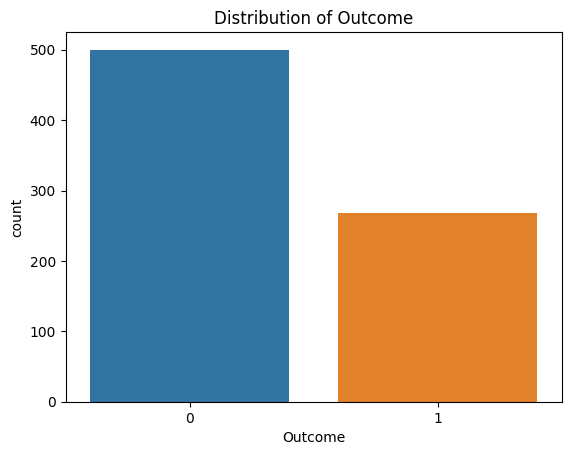

In [28]:
# Checking the distribution of the outcome variable
sns.countplot(x='Outcome', data=diabetes_data)
plt.title('Distribution of Outcome')
plt.show()

## Feature Engineering

In [29]:
# Splitting the dataset into features and target variable
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Reshaping the features for compatibility with Conv1D
input_shape = (8, 1)  # Number of independent features

# Reshape the input data for compatibility with Conv1D
X_train_reshaped = X_train.values.reshape(-1, input_shape[0], 1)
X_test_reshaped = X_test.values.reshape(-1, input_shape[0], 1)

In [33]:
# Create the CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=1),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=1),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Assuming binary classification (0 or 1)
])

In [34]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

In [35]:
# Print model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 6, 32)             128       
                                                                 
 max_pooling1d_21 (MaxPooli  (None, 6, 32)             0         
 ng1D)                                                           
                                                                 
 conv1d_22 (Conv1D)          (None, 4, 64)             6208      
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 4, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_23 (Conv1D)          (None, 2, 128)            24704     
                                                                 
 max_pooling1d_23 (MaxPooli  (None, 2, 128)           

In [36]:
# Train the model
history = model.fit(X_train_reshaped, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test_reshaped, y_test))

Epoch 1/10


20/20 [==============================] - 3s 36ms/step - loss: 1.3663 - accuracy: 0.5733 - val_loss: 0.7250 - val_accuracy: 0.6818
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 0.8811 - accuracy: 0.6140 - val_loss: 0.7264 - val_accuracy: 0.6623
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.6508 - accuracy: 0.6547 - val_loss: 0.6504 - val_accuracy: 0.6818
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.6563 - accuracy: 0.6417 - val_loss: 0.6488 - val_accuracy: 0.6558
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.5985 - accuracy: 0.6922 - val_loss: 0.6390 - val_accuracy: 0.6104
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 0.6052 - accuracy: 0.6336 - val_loss: 0.6086 - val_accuracy: 0.7273
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.6344 - accuracy: 0.6596 - val_loss: 0.6200 - val_accuracy: 0.6688
Epoch 8/10
20/